In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import auc, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

from SepMe.processing.batchprocessing import *

import warnings
warnings.filterwarnings('ignore')

SepMe - INFO - MLFLOW_TRACKING_URI - http://localhost:5000


In [13]:
df = pd.read_csv('lazy_all.csv')


df['human_bin'] = 'no'
df.loc[(df['human_rating'].between(50,100)), 'human_bin'] = 'yes'

df['expert_bin'] = 'maybe'
df.loc[(df['M'].isin([4,5])) & (df['A'].isin([4,5])), 'expert_bin'] = 'yes'
df.loc[(df['M'].isin([1,2])) & (df['A'].isin([1,2])), 'expert_bin'] = 'no'



#df['M'] = minmax_scale(df['M'])
#df['A'] = minmax_scale(df['A'])
df['human_rating'] = minmax_scale(df['human_rating'])


df = df.loc[df['1v1']==False]
df = df.loc[df['pass']==1]

print(df.columns)

Index(['filename', 'type', '1v1', 'phase', 'human_rating', 'idx', 'pass',
       'as_0.02_ce', 'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_ce',
       'bt_0.05_cp', 'bt_0.05_ltcc', 'bt_0.1_ce', 'bt_0.1_cp', 'bt_0.1_ltcc',
       'bt_0.5_ce', 'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc', 'index', 'M', 'A',

In [14]:
#reproducing old sepme
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95


def bootstrap_aoc(df, bs=50, sample=1000, target_col='human_bin', thresh = .95):
    
    aucs = {}
    for col in df.columns[7:-2]:

        if df[col].dtype =='float64':
            #print(col)
            df.loc[:, 'a'] = 1 - df[col]
            a = np.array(df.loc[:,target_col].copy())
            b = np.array(df.loc[:, 'a'].copy())

            stuff =[]
            for i in range(bs):
                idx = random.sample(list(np.arange(len(a))),sample)
                stuff.append(roc_auc_score(a[idx],b[idx]))

            n = len(stuff)
            m = mean(stuff)
            std_err = sem(stuff)
            h = std_err * t.ppf((1 + confidence) / 2, n - 1)

            aucs[col] = {}
            aucs[col]['mean'] = m
            aucs[col]['start'] = m-h
            aucs[col]['end'] = m+h
            
            if aucs[col]['mean']>thresh:
                print(col)
                b = np.array(df.loc[:, [col,'a']].copy())
                skplt.metrics.plot_roc(a,b)
                plt.show()



    aucs = pd.DataFrame.from_dict(aucs, orient='index').reset_index()
    aucs.columns = ['type','value','ci-','ci+'] 
    aucs = aucs.sort_values('value', ascending=False)
    aucs['spread'] = aucs['ci+'] -aucs['ci-']
    return aucs


(9267, 68)
bt_0.05_ce


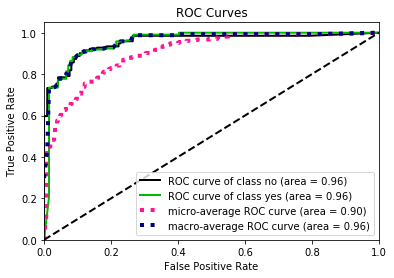

,type,value,ci-,ci+,spread
14,bt_0.05_ce,0.958413,0.956644,0.960182,0.003538
17,bt_0.1_ce,0.947370,0.945782,0.948958,0.003176
40,knn_1.0_ce,0.945330,0.943768,0.946893,0.003125
49,knn_6.0_ce,0.942590,0.941043,0.944137,0.003094
46,knn_4.0_ce,0.941330,0.939314,0.943346,0.004032
43,knn_2.0_ce,0.939061,0.936790,0.941331,0.004542
52,knn_8.0_ce,0.938064,0.935966,0.940161,0.004195
26,cbsg_0.2_ce,0.932989,0.931033,0.934946,0.003913
29,cbsg_0.5_ce,0.932065,0.929594,0.934535,0.004942
32,cbsg_2.0_ce,0.932008,0.929766,0.934249,0.004483


In [15]:
df_exp = df.loc[(df['expert_bin'].isin(['yes','no']))]
print(df_exp.shape)
aucs_human = bootstrap_aoc(df_exp, target_col='expert_bin')
aucs_human.head(20)

In [11]:
df_exp = df.loc[(df['expert_bin'].isin(['yes','maybe']))]
print(df_exp.shape)
aucs_human = bootstrap_aoc(df_exp, target_col='expert_bin')
aucs_human.head(20)

(10573, 68)


,type,value,ci-,ci+,spread
6,as_0.1_ce,0.807552,0.803473,0.811631,0.008158
9,as_0.5_ce,0.806280,0.801865,0.810695,0.008830
0,as_0.02_ce,0.805645,0.802162,0.809129,0.006968
43,knn_2.0_ce,0.805397,0.801301,0.809494,0.008193
3,as_0.05_ce,0.805086,0.801415,0.808757,0.007343
46,knn_4.0_ce,0.804504,0.800796,0.808212,0.007416
32,cbsg_2.0_ce,0.801397,0.797670,0.805125,0.007454
35,del_n/a_ce,0.800670,0.796901,0.804438,0.007538
17,bt_0.1_ce,0.799487,0.795353,0.803621,0.008268
49,knn_6.0_ce,0.799276,0.794802,0.803750,0.008948


In [12]:

df_exp = df.loc[(df['expert_bin'].isin(['maybe','no']))]
print(df_exp.shape)
aucs_human = bootstrap_aoc(df_exp, target_col='expert_bin')
aucs_human.head(20)




(9821, 68)


,type,value,ci-,ci+,spread
54,knn_8.0_ltcc,0.863420,0.860115,0.866726,0.006611
25,cbsg_0.1_ltcc,0.860973,0.858043,0.863902,0.005859
37,del_n/a_ltcc,0.858909,0.855341,0.862477,0.007136
11,as_0.5_ltcc,0.856422,0.853144,0.859700,0.006556
8,as_0.1_ltcc,0.856299,0.853903,0.858695,0.004792
5,as_0.05_ltcc,0.855630,0.853341,0.857920,0.004578
2,as_0.02_ltcc,0.855460,0.852452,0.858469,0.006016
28,cbsg_0.2_ltcc,0.855054,0.851995,0.858112,0.006117
36,del_n/a_cp,0.852491,0.848500,0.856482,0.007981
38,del_n/a_mv_false,0.847978,0.845551,0.850405,0.004854


as_0.02_ce


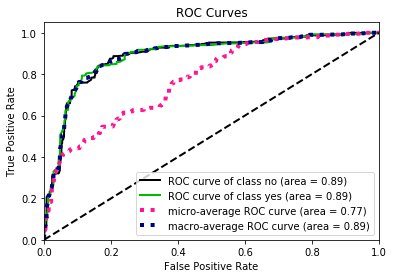

as_0.05_ce


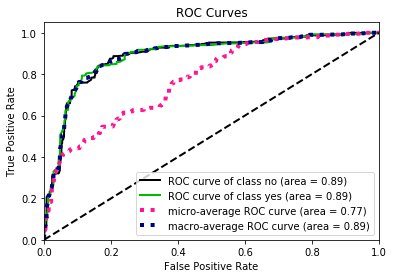

as_0.1_ce


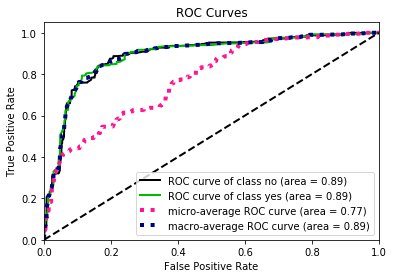

as_0.5_ce


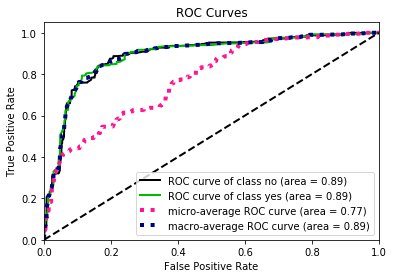

bt_0.05_ce


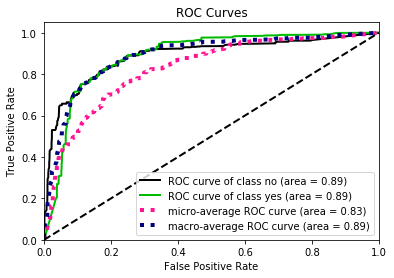

bt_0.1_ce


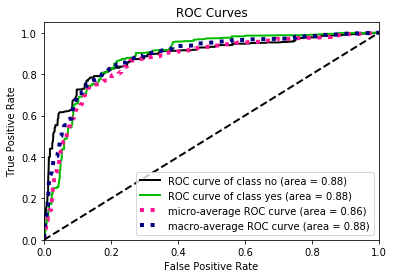

cbsg_0.1_ce


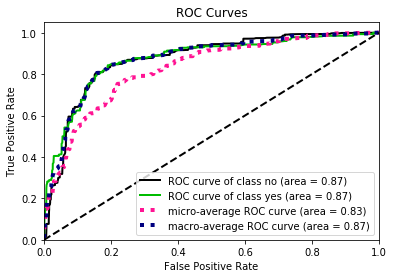

cbsg_0.2_ce


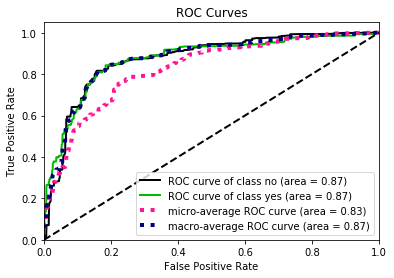

cbsg_0.5_ce


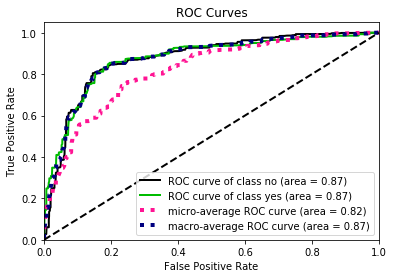

cbsg_2.0_ce


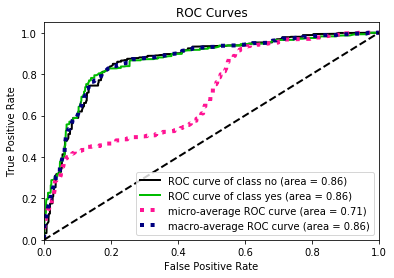

del_n/a_ce


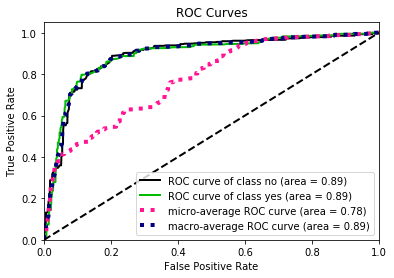

knn_1.0_ce


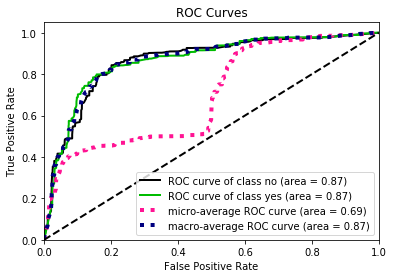

knn_2.0_ce


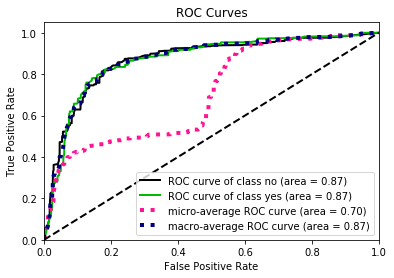

knn_4.0_ce


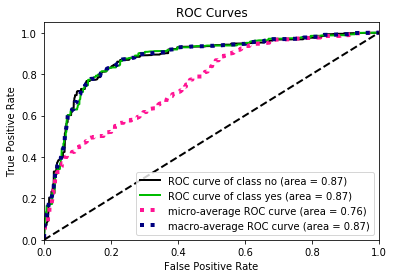

knn_6.0_ce


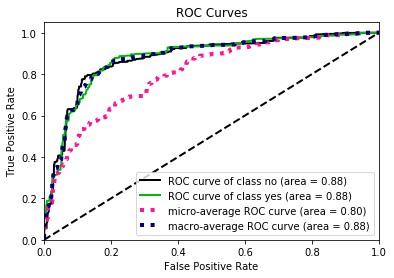

knn_8.0_ce


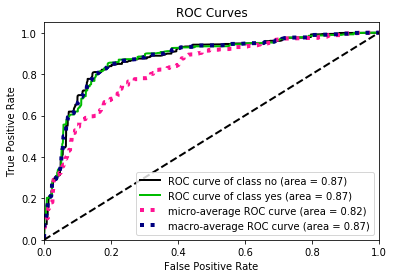

,type,value,ci-,ci+,spread
35,del_n/a_ce,0.893068,0.890257,0.895878,0.005621
0,as_0.02_ce,0.890236,0.887236,0.893237,0.006001
9,as_0.5_ce,0.889713,0.886901,0.892526,0.005625
14,bt_0.05_ce,0.888510,0.885202,0.891819,0.006616
6,as_0.1_ce,0.887667,0.885083,0.890252,0.005169
3,as_0.05_ce,0.886980,0.883813,0.890147,0.006334
17,bt_0.1_ce,0.881175,0.878022,0.884328,0.006306
49,knn_6.0_ce,0.878819,0.875993,0.881644,0.005651
46,knn_4.0_ce,0.875185,0.872040,0.878331,0.006291
52,knn_8.0_ce,0.874417,0.871687,0.877147,0.005460


In [17]:
df_exp = df.loc[(df['expert_bin'].isin(['yes','no']))]
aucs_human = bootstrap_aoc(df_exp, target_col='human_bin',thresh = .75)
aucs_human.head(20)

In [35]:
aucs_human.head(20)

,type,value,ci-,ci+,spread
35,del_n/a_ce,0.725934,0.723097,0.728771,0.005673
6,as_0.1_ce,0.724826,0.721893,0.727759,0.005866
9,as_0.5_ce,0.724764,0.721648,0.727881,0.006232
0,as_0.02_ce,0.724205,0.720946,0.727463,0.006516
3,as_0.05_ce,0.724172,0.720798,0.727545,0.006747
49,knn_6.0_ce,0.723139,0.719967,0.726311,0.006345
14,bt_0.05_ce,0.722476,0.719315,0.725636,0.006321
17,bt_0.1_ce,0.720854,0.717918,0.723790,0.005872
29,cbsg_0.5_ce,0.719878,0.716917,0.722839,0.005922
46,knn_4.0_ce,0.719159,0.715958,0.722360,0.006402


In [8]:
df.columns

Index(['filename', 'type', '1v1', 'phase', 'human_rating', 'idx', 'pass',
       'as_0.02_ce', 'as_0.02_cp', 'as_0.02_ltcc', 'as_0.05_ce', 'as_0.05_cp',
       'as_0.05_ltcc', 'as_0.1_ce', 'as_0.1_cp', 'as_0.1_ltcc', 'as_0.5_ce',
       'as_0.5_cp', 'as_0.5_ltcc', 'bt_0.02_cp', 'bt_0.02_ltcc', 'bt_0.05_ce',
       'bt_0.05_cp', 'bt_0.05_ltcc', 'bt_0.1_ce', 'bt_0.1_cp', 'bt_0.1_ltcc',
       'bt_0.5_ce', 'bt_0.5_cp', 'bt_0.5_ltcc', 'cbsg_0.1_ce', 'cbsg_0.1_cp',
       'cbsg_0.1_ltcc', 'cbsg_0.2_ce', 'cbsg_0.2_cp', 'cbsg_0.2_ltcc',
       'cbsg_0.5_ce', 'cbsg_0.5_cp', 'cbsg_0.5_ltcc', 'cbsg_2.0_ce',
       'cbsg_2.0_cp', 'cbsg_2.0_ltcc', 'del_n/a_ce', 'del_n/a_cp',
       'del_n/a_ltcc', 'del_n/a_mv_false', 'del_n/a_mv_true', 'knn_1.0_ce',
       'knn_1.0_cp', 'knn_1.0_ltcc', 'knn_2.0_ce', 'knn_2.0_cp',
       'knn_2.0_ltcc', 'knn_4.0_ce', 'knn_4.0_cp', 'knn_4.0_ltcc',
       'knn_6.0_ce', 'knn_6.0_cp', 'knn_6.0_ltcc', 'knn_8.0_ce', 'knn_8.0_cp',
       'knn_8.0_ltcc', 'index', 'M', 'A',

In [9]:
df['consensus'] = 'no'
df.loc[(df['human_bin']=='yes') & (df['expert_bin']=='yes'), 'consensus'] = 'yes'
df.loc[(df['human_bin']=='no') & (df['expert_bin']=='no'), 'consensus'] = 'yes'
df['consensus'].value_counts()

yes    8661
no     7616
Name: consensus, dtype: int64

In [10]:
df['consensus'] = 'no'
df.loc[(df['human_bin']=='yes') & (df['expert_bin']=='yes'), 'consensus'] = 'yes'
#df.loc[(df['human_bin']=='no') & (df['expert_bin']=='no'), 'consensus'] = 'yes'
df['consensus'].value_counts()


no     11536
yes     4741
Name: consensus, dtype: int64

In [11]:
df.loc[df['class']==1]

,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin,consensus
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.73,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes,yes
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.83,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes,yes
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.72,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes,yes
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.77,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes,yes
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.83,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28100,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes,yes
28101,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.78,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes,yes
28102,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.80,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes,yes
28103,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.84,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.000000,...,0.018563,0.987805,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes,yes


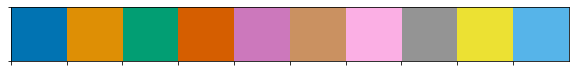

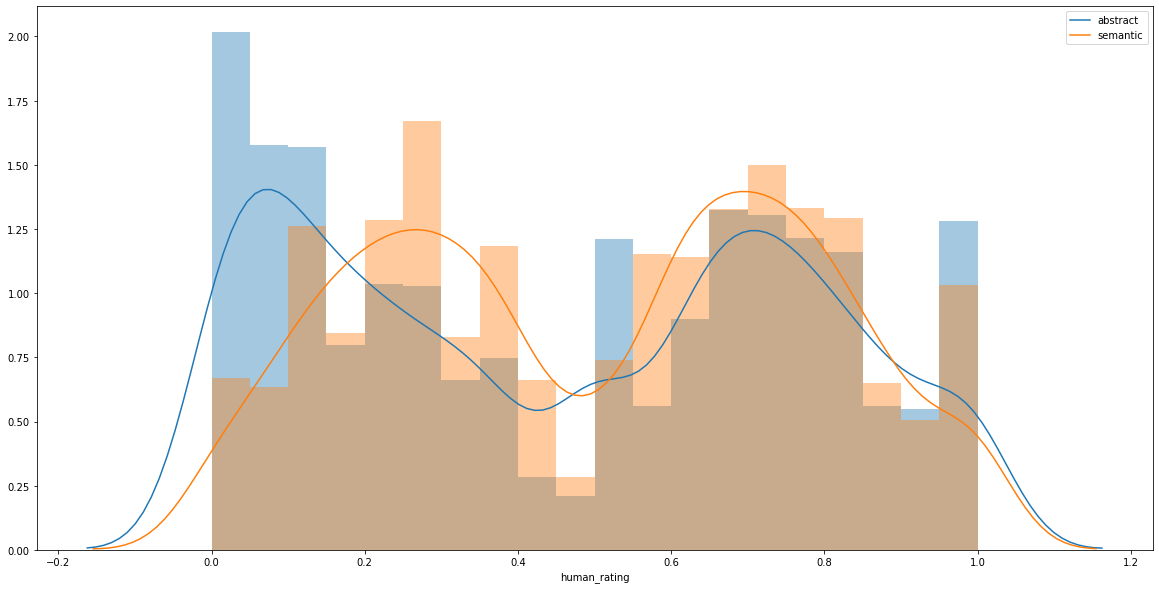

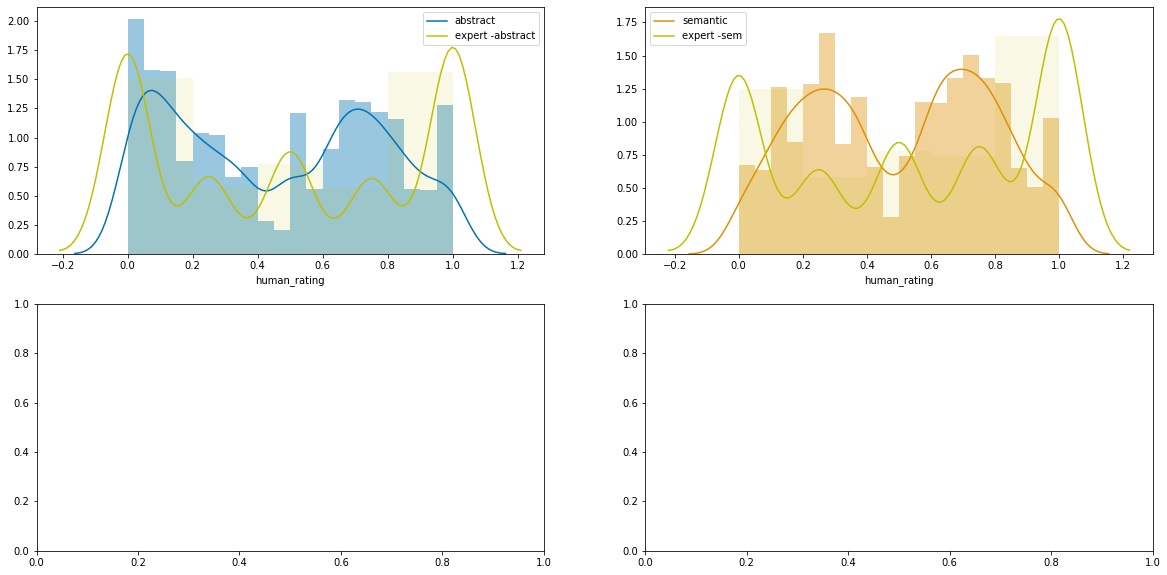

In [19]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)






df1,df2 = get_dfs(df)

fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df1.human_rating, bins=20, kde_kws={"label": "abstract"})
sns.distplot(df2.human_rating, bins=20, kde_kws={"label": "semantic"})


# sns.distplot(minmax_scale(df1.M), bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "expert -abstract"})
# sns.distplot(minmax_scale(df2.M), bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "expert -sem"})
# sns.distplot(df3.A, bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "A -abstract -1v1"})
# sns.distplot(df4.A, bins=5, color='b', hist_kws=dict(alpha=.1), kde_kws={"label": "A -sem -1v1"})




fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.distplot(df1.human_rating, bins=20, kde_kws={"label": "abstract"}, ax=ax[0,0], color = current_palette[0])
sns.distplot(df2.human_rating, bins=20, kde_kws={"label": "semantic"}, ax=ax[0,1], color = current_palette[1])



sns.distplot(minmax_scale(df1.M), bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "expert -abstract"}, ax=ax[0,0])
sns.distplot(minmax_scale(df2.M), bins=5, color='y', hist_kws=dict(alpha=.1), kde_kws={"label": "expert -sem"}, ax=ax[0,1])



In [ ]:
df

In [49]:
## normalize df by scenario

dd = df.copy()
for tt in set(df['type']):
    for vv in set(df['1v1']):
        print(tt + str(vv))
        dd.loc[(df['type']==tt) & (df['1v1']==vv), 'human_rating'] = minmax_scale(df.loc[(df['type']==tt) & (df['1v1']==vv), 'human_rating'])

dd



abstractFalse
semanticFalse


,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_6.0_ltcc,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.17,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,no,yes
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.21,JavierGeneratedData_3dinterleaved_3classes_Gli...,0.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,no,yes
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.78,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.86,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.85,JavierGeneratedData_3dinterleaved_3classes_Gli...,1.0,0.076577,0.957971,0.993711,...,0.993711,0.045652,0.966195,0.993711,JavierGeneratedData_3dinterleaved_3classes_Gli...,5,5,1,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28180,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28181,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.97,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28182,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.83,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28183,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.60,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.000000,...,1.000000,0.019895,0.990260,1.000000,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes


114


,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.807250,40,0.017071,5,5,40.0,0.071447,0.000821
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.689444,36,0.043201,5,5,30.0,0.071447,0.000867
2,JavierGeneratedData_3dinterleaved_4classes_PCA,abstract,False,training,0.706833,60,0.025334,4,5,51.0,0.159766,0.002993
3,JavierGeneratedData_3dinterleaved_4classes_PCA,semantic,False,training,0.578667,60,0.028143,4,5,60.0,0.159766,0.002993
4,JavierGeneratedData_3dinterleaved_4classes_RobPCA,abstract,False,task,0.660333,60,0.030517,4,5,54.0,0.195328,0.002896
...,...,...,...,...,...,...,...,...,...,...,...,...
225,worldmap_PCA,semantic,False,task,0.461458,48,0.044079,5,5,43.0,0.260689,0.001349
226,worldmap_RobPCA,abstract,False,task,0.564573,164,0.025169,5,5,133.0,0.211759,0.003051
227,worldmap_RobPCA,semantic,False,task,0.529000,80,0.031625,5,5,68.0,0.211759,0.004382
228,yeast_PCA,abstract,False,task,0.302187,160,0.021392,1,1,117.0,0.436849,0.002852


,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem,start,end,spread
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,False,task,0.807250,40,0.017071,5,5,40.0,0.071447,0.000821,0.772721,0.841779,0.069057
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,False,task,0.689444,36,0.043201,5,5,30.0,0.071447,0.000867,0.601741,0.777147,0.175406
2,JavierGeneratedData_3dinterleaved_4classes_PCA,abstract,False,training,0.706833,60,0.025334,4,5,51.0,0.159766,0.002993,0.656139,0.757528,0.101388
3,JavierGeneratedData_3dinterleaved_4classes_PCA,semantic,False,training,0.578667,60,0.028143,4,5,60.0,0.159766,0.002993,0.522354,0.634980,0.112626
4,JavierGeneratedData_3dinterleaved_4classes_RobPCA,abstract,False,task,0.660333,60,0.030517,4,5,54.0,0.195328,0.002896,0.599269,0.721398,0.122129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,worldmap_PCA,semantic,False,task,0.461458,48,0.044079,5,5,43.0,0.260689,0.001349,0.372782,0.550135,0.177353
226,worldmap_RobPCA,abstract,False,task,0.564573,164,0.025169,5,5,133.0,0.211759,0.003051,0.514874,0.614272,0.099398
227,worldmap_RobPCA,semantic,False,task,0.529000,80,0.031625,5,5,68.0,0.211759,0.004382,0.466052,0.591948,0.125896
228,yeast_PCA,abstract,False,task,0.302187,160,0.021392,1,1,117.0,0.436849,0.002852,0.259937,0.344438,0.084500


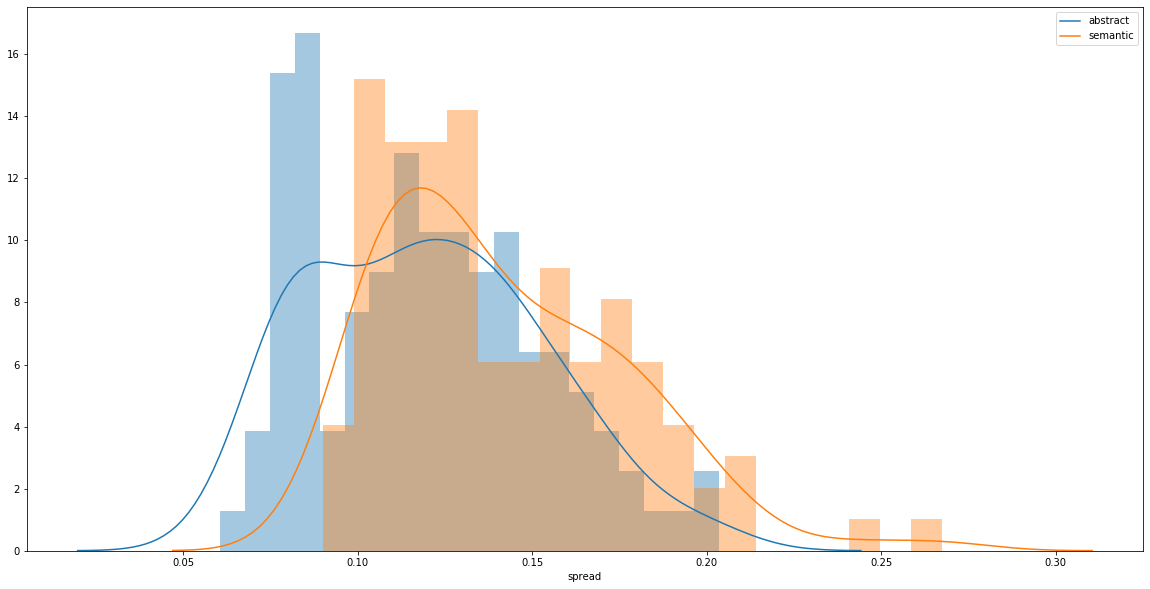

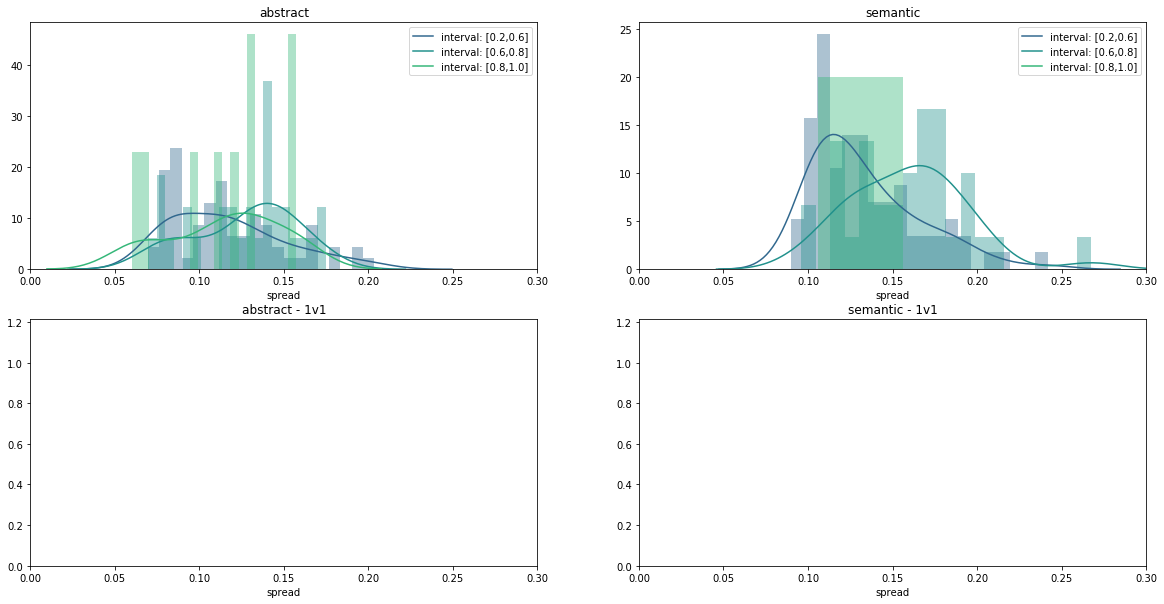

In [54]:
df_agg = (df.groupby(['filename','type','1v1','phase'])
     .agg({'human_rating':['mean', 'count', sem], 
           'M':'first', 'A':'first', 'pass':'sum',
          'as_0.1_ce':['mean', sem]}))

df_agg.columns = ["%s%s" % (a, ".%s" % b if b else "") for a, b in df_agg.columns]

df_agg = df_agg.reset_index()
print(len(set(df_agg.filename)))
df_agg



confidence =.95
h = df_agg['human_rating.sem'] * t.ppf((1 + confidence) / 2, df_agg['human_rating.count'] - 1)

df_agg['start'] = df_agg['human_rating.mean']-h
df_agg['end'] = df_agg['human_rating.mean']+h
df_agg['spread'] = df_agg['end'] - df_agg['start']

df1,df2,df3,df4 = get_dfs(df_agg)
dfs = [df1,df2,df3,df4]  

fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df1.spread, bins=20, kde_kws={"label": "abstract"})
sns.distplot(df2.spread, bins=20, kde_kws={"label": "semantic"})
sns.distplot(df3.spread, bins=20, kde_kws={"label": "abstract - 1v1"})
sns.distplot(df4.spread, bins=20, kde_kws={"label": "semantic - 1v1"})



intervals = [0,.2,.6,.8,1.00]
col = 'human_rating.mean'

names = ['abstract','semantic','abstract - 1v1', 'semantic - 1v1']
colors = sns.color_palette("viridis", len(intervals))


fig, ax = plt.subplots(2,2,figsize=(20,10))
for j, dd in enumerate(dfs):
    
    for i, ints in enumerate(intervals):
        if i!=len(intervals)-1:
            dd1 = dd.loc[dd[col].between(intervals[i], intervals[i+1])]
            #print('before {} - after {}'.format(len(dd), len(dd1)))
            sns.distplot(dd1.spread, bins=20, ax = ax[j//2, j%2],
                         color = colors[i],
                        kde_kws={"label": "interval: [{},{}]"
                                 .format(intervals[i], intervals[i+1])}).set_title(names[j])
            
    ax[j//2, j%2].set_xlim(0,.3)
            
        


df_agg
            

In [61]:
sns.color_palette("Oranges")

[(0.9955709342560554, 0.8907958477508651, 0.7855132641291811),
 (0.9921568627450981, 0.7769934640522875, 0.5727028066128412),
 (0.9921568627450981, 0.6280507497116494, 0.34226835832372166),
 (0.9648442906574395, 0.47100346020761247, 0.14197616301422528),
 (0.8782929642445213, 0.31990772779700116, 0.024405997693194924),
 (0.6768627450980392, 0.22089965397923875, 0.010749711649365626)]

In [86]:
s = [.1,.2,.6]
minmax_scale(s)

array([0. , 0.2, 1. ])

In [57]:
df_agg.loc[df_agg['filename'] == 'ms_interleaved_60_120_3d_0_centeredClusters_RobPCA' ]

,filename,type,1v1,phase,human_rating.mean,human_rating.count,human_rating.sem,M.first,A.first,pass.sum,as_0.1_ce.mean,as_0.1_ce.sem,start,end,spread
148,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.79025,40,0.029414,5,5,37.0,0.072607,0.00182,0.730754,0.849746,0.118991
149,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.71300,40,0.032860,5,5,35.0,0.072607,0.00182,0.646535,0.779465,0.132931


,filename,type,1v1,phase,human_rating,idx,pass,as_0.02_ce,as_0.02_cp,as_0.02_ltcc,...,knn_6.0_ltcc,knn_8.0_ce,knn_8.0_cp,knn_8.0_ltcc,index,M,A,class,human_bin,expert_bin
28045,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.78,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28046,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.67,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28047,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.89,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28048,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.85,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
28049,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,semantic,False,training,0.63,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.083975,0.948282,1.0,...,1.0,0.018563,0.987805,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,1,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28180,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,1.00,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28181,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.97,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28182,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.83,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes
28183,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,abstract,False,training,0.60,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,1.0,0.061238,0.961472,1.0,...,1.0,0.019895,0.990260,1.0,ms_interleaved_60_120_3d_0_centeredClusters_Ro...,5,5,2,yes,yes


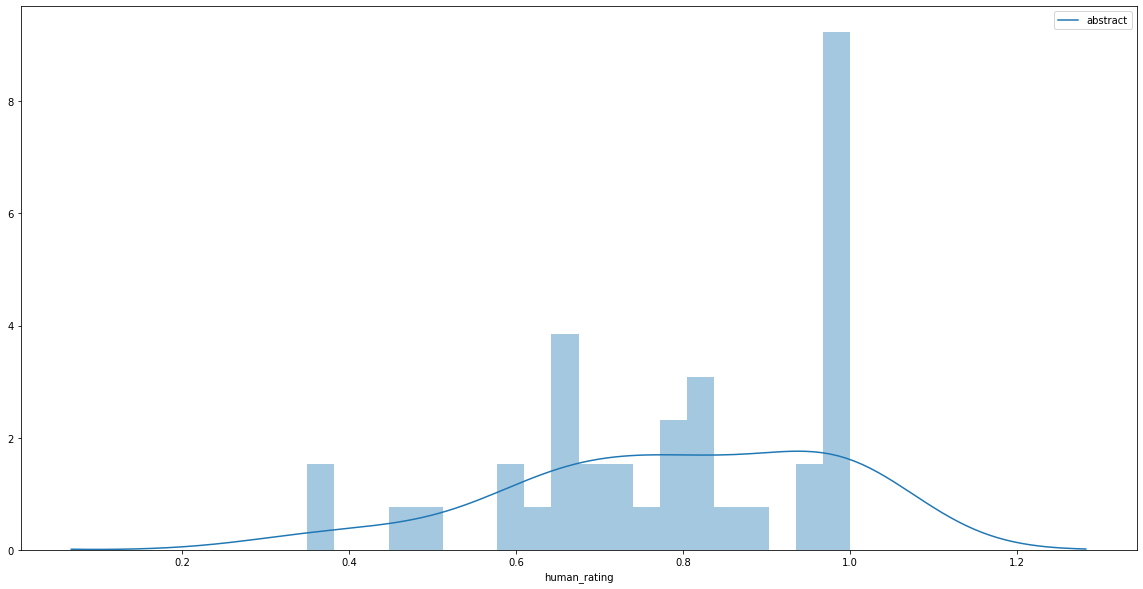

In [65]:
fig, ax = plt.subplots(figsize=(20,10))

ddd = df.loc[df['filename'] == 'ms_interleaved_60_120_3d_0_centeredClusters_RobPCA' ]


df1,df2,df3,df4 = get_dfs(ddd)
dfs = [df1,df2,df3,df4]  


sns.distplot(ddd.loc[ddd['type'] == 'abstract','human_rating' ], bins=20, kde_kws={"label": "abstract"})
#sns.distplot(ddd.loc[ddd['type'] == 'semantic','human_rating' ], bins=20, kde_kws={"label": "semantic"})

